# Market Data

The trade data for this project is acquired from [Poloniex](https://poloniex.com) exchange, which is the number 1 crypto currency exchange by [daily volume](http://coinmarketcap.com/exchanges/volume/24-hour/). 

From Poloniex we are able to acquire [historical trade data](#Historical-Trade-Data), real-time orderbook data and real-time trollbox data. We start by acquiring the historical trade data and standardizing our samples across markets. We also acquire the real-time data and save it for incorporation in the training model. 

In [1]:
import os
import json
import time
import requests
%matplotlib inline
from pylab import *
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

from IPython.core.display import HTML
HTML('<style>{}</style>'.format( open('style.css').read() ) )

** Create function for requesting Poloniex data **

In [2]:
def poloniex_api(command, args={}):
    url = 'https://poloniex.com/public?command='+command
    for arg, value in args.items():
        url += '&{}={}'.format(arg,value)
    return json.loads(requests.get(url).content.decode('utf-8'))

## Historical Trade Data
The trade data wrangling process requires that we group and standardize the time series data according to time interval. We then group our sample populations by trade type(i.e. buy or sell) and volume level (e.g. high). 



#### Top markets by daily trade volume
First, lets get the markets with the highest daily volume. To keep things simple we only look at BTC denominated markets.

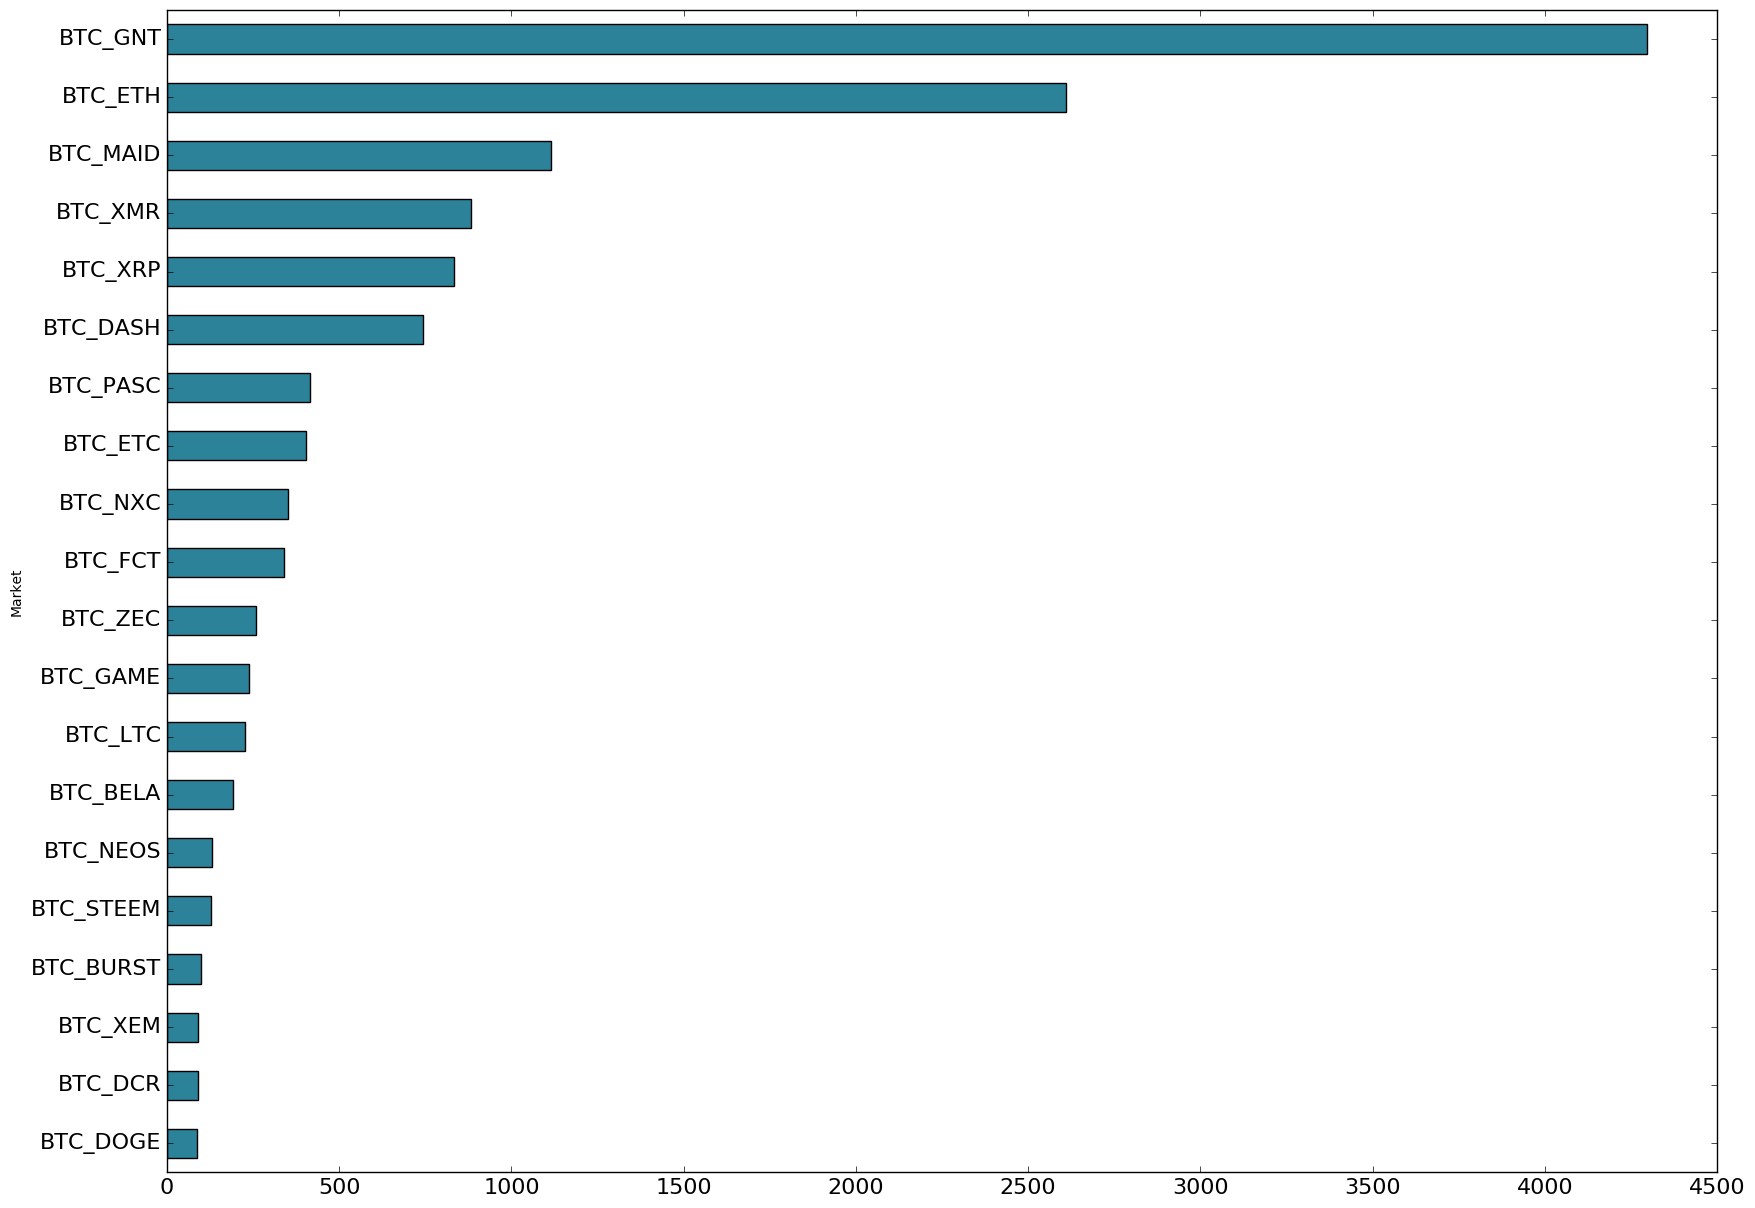

In [3]:
market_volumes = poloniex_api('return24hVolume')
btc_market_volumes = [(m, float(market_volumes[m]['BTC'])) for m in market_volumes if m[:3] == 'BTC']
top_markets = (pd.DataFrame(btc_market_volumes, columns=['Market','Volume'])
     .set_index('Market').sort_values(by='Volume', ascending=False).head(20))

top_markets.Volume.sort_values(0).plot(kind='barh', figsize=(20,15), fontsize=16, color='#2C8399')

#### Acquiring trade data

The function *get_trade* pulls trade data for a given market and from a specified period of time. If the query result is to big to keep in memory the data is requested in chuncks and saved to an output file. 

In [5]:
def unix_time(dt):
    return int(time.mktime(dt.timetuple()))

def format_dtypes(df):
    trades = df.copy()
    for col in ['amount','rate','total']:
        trades[col] = trades[col].astype(float, raise_on_error=False)
    trades['date'] = pd.to_datetime(trades.date)
    trades = trades.set_index('date')
    trades['type'] = trades.type.str.contains('buy') * 1

    return trades

In [52]:
def get_trades(currency_pair, start, end):
    
    trades_df = pd.DataFrame()
    
    need_to_fetch = lambda t: len(t) == 0 or t.tradeID['count'].sum() % 50000 == 0
    while need_to_fetch(trades_df):
        
        print(start, end)
        new_trades = pd.DataFrame(
            poloniex_api('returnTradeHistory', {
                'currencyPair': currency_pair,
                'start': unix_time(start),
                'end': unix_time(end)
            }))
        
        if new_trades.empty:
            break
        
        trades = format_dtypes(new_trades)
        end = trades.index.min() # reset the end 
        
        # group trades by hour
        trades['hour'] = trades.index.to_period('1H')
        hourly_stats = trades.groupby('hour').describe().unstack()
        
        # account for overlap in period indes
        if not trades_df.empty and trades_df.index.min() == hourly_stats.index.max():
            row1 = trades_df.ix[trades_df.index.min()]
            row2 = hourly_stats.ix[trades_df.index.min()]
            trade_count = (row1.tradeID['count'] + row2.tradeID['count'])
            new_row = (
                ((row1 * row1.tradeID['count']) + (row2 * row2.tradeID['count'])) /  trade_count 
            )
            
            for col in new_row.index.levels[0]:
                new_row[col]['count'] = trade_count
            
            trades_df.ix[trades_df.index.min()] = new_row
            
            hourly_stats = hourly_stats[hourly_stats.index != trades_df.index.min()]
        
        trades_df = pd.concat([trades_df, hourly_stats])
        
        time.sleep(0.5)
    
    print('acquired {} total trades'.format(trades_df.tradeID['count'].sum()))
    return trades_df

In [7]:
#trades = get_trades('BTC_ETH', datetime(2017,1,1), datetime(2017,1,10))

## Markets 

The most consistently high volume markets are the Bitcoin, Ethereum and Monero markets. I get the trade data for these markets from the past year, beginning in February. 

In [8]:
top_markets.Volume.sort_values(ascending=False).head().index.tolist()

['BTC_GNT', 'BTC_ETH', 'BTC_MAID', 'BTC_XMR', 'BTC_XRP']

In [59]:
markets = ['USDT_BTC'] + top_markets.Volume.sort_values(ascending=False).head().index.tolist()[1:]
trade_data = {}

for market in markets:
    print('fetching {} market data'.format(market))
    trade_data[market.split('_')[1]] = get_trades(market, datetime(2016,12,15), datetime(2017,1,1))

fetching USDT_BTC market data
2016-12-15 00:00:00 2017-01-01 00:00:00
2016-12-15 00:00:00 2016-12-22 16:32:05
acquired 69279.0 total trades
fetching BTC_ETH market data
2016-12-15 00:00:00 2017-01-01 00:00:00
2016-12-15 00:00:00 2016-12-29 12:55:16
2016-12-15 00:00:00 2016-12-27 19:23:13
2016-12-15 00:00:00 2016-12-24 07:04:25
2016-12-15 00:00:00 2016-12-22 09:27:59
2016-12-15 00:00:00 2016-12-19 20:06:51
2016-12-15 00:00:00 2016-12-16 19:05:51
acquired 334362.0 total trades
fetching BTC_MAID market data
2016-12-15 00:00:00 2017-01-01 00:00:00
2016-12-15 00:00:00 2016-12-21 21:01:01
acquired 82855.0 total trades
fetching BTC_XMR market data
2016-12-15 00:00:00 2017-01-01 00:00:00
2016-12-15 00:00:00 2016-12-29 08:42:57
2016-12-15 00:00:00 2016-12-28 06:59:35
2016-12-15 00:00:00 2016-12-27 05:26:05
2016-12-15 00:00:00 2016-12-23 19:41:41
2016-12-15 00:00:00 2016-12-21 15:28:10
2016-12-15 00:00:00 2016-12-18 02:55:43
acquired 332998.0 total trades
fetching BTC_XRP market data
2016-12-15 

In [60]:
for market, trades in trade_data.items():
    print('{}: {} samples'.format(market,trades.shape[0]))

XMR: 408 samples
MAID: 408 samples
ETH: 408 samples
XRP: 409 samples
BTC: 408 samples


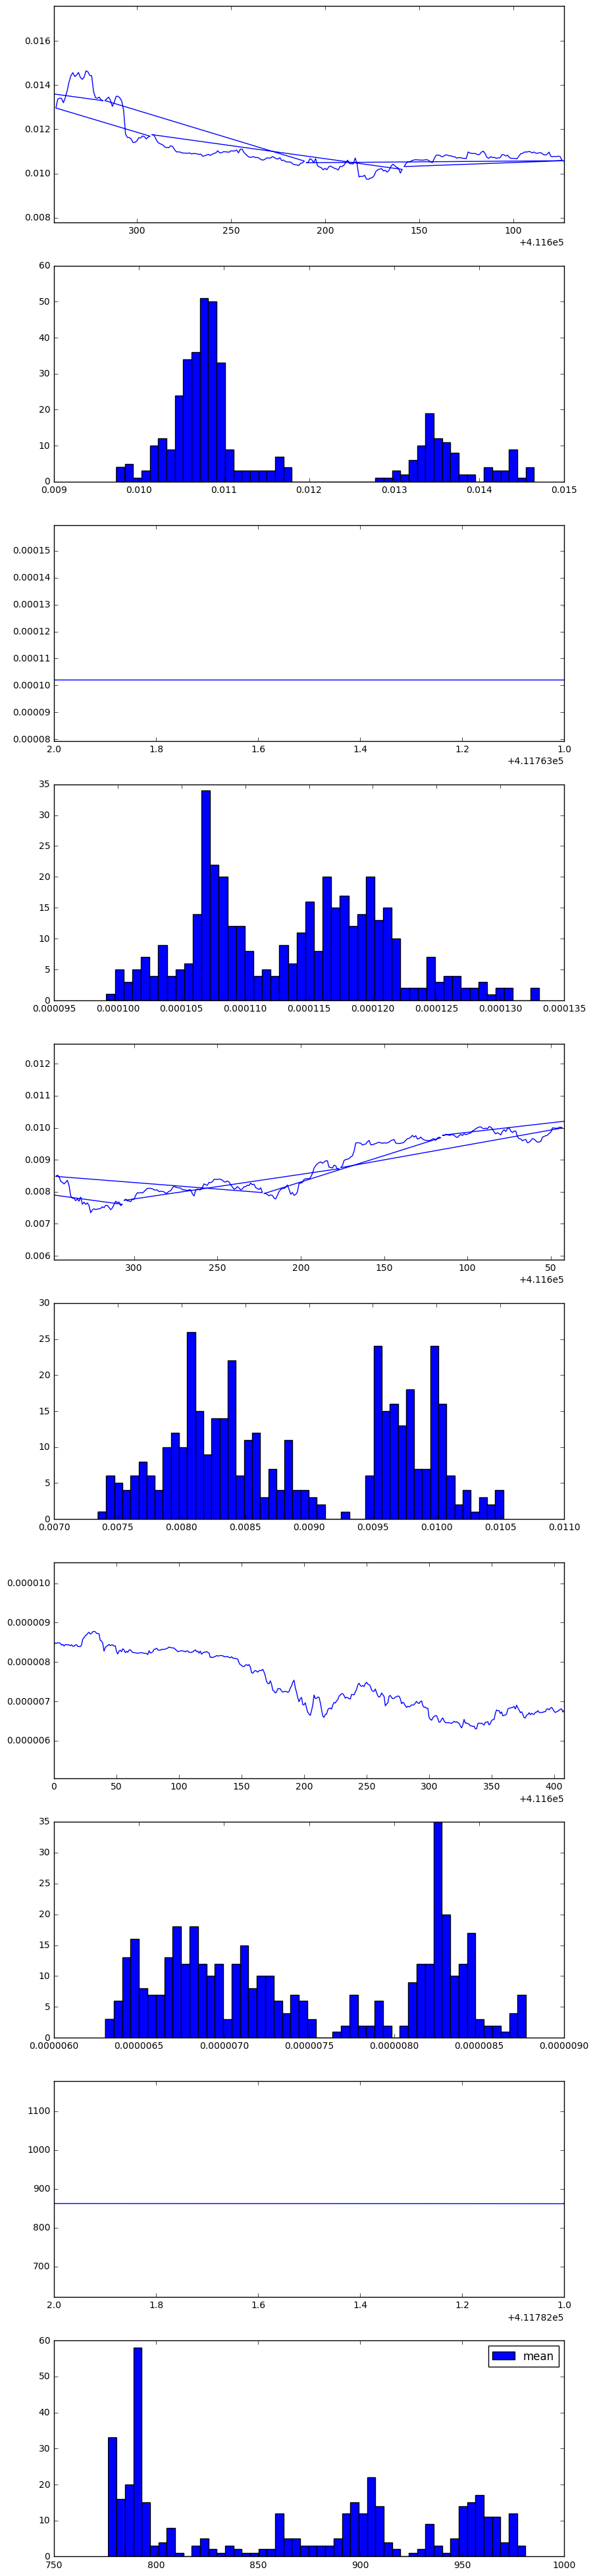

In [175]:

f, axes = plt.subplots(len(markets)*2, figsize=(10,len(markets)*10))

for i, (market, trades)  in enumerate(trade_data.items()):
        #plt.hist(trades.rate['mean'], bins=50)
        ax_ind = 2*i
        axes[ax_ind].plot(trades.index.values, trades.rate['mean'].values,label=market)
        axes[ax_ind].set_xlim(trades.index.values[0],trades.index.values[-1])
        axes[ax_ind].set_ylim(trades.rate['mean'].min()*0.8, trades.rate['mean'].max()*1.2)
        axes[ax_ind+1].hist(trades.rate['mean'], bins=50)

plt.legend()     
plt.show()

In [292]:
# ma_cross.py

class MovingAverageCrossStrategy:
    """    
    Requires:
    symbol - A stock symbol on which to form a strategy on.
    bars - A DataFrame of bars for the above symbol.
    short_window - Lookback period for short moving average.
    long_window - Lookback period for long moving average."""

    def __init__(self, prices, short_window=12, long_window=36):
        self.prices = prices

        self.short_window = short_window
        self.long_window = long_window

    def generate_signals(self):
        """Returns the DataFrame of symbols containing the signals
        to go long, short or hold (1, -1 or 0)."""
        signals = pd.DataFrame(index=self.prices.index)
        signals['signal'] = 0.0

        # Create the set of short and long simple moving averages over the 
        # respective periods
        signals['short_mavg'] = self.prices.rolling(window=self.short_window, min_periods=1).mean()
        signals['long_mavg'] = self.prices.rolling(window=self.long_window, min_periods=1).mean()

        # Create a 'signal' (invested or not invested) when the short moving average crosses the long
        # moving average, but only for the period greater than the shortest moving average window
        signals['signal'][self.short_window:] = np.where(signals['short_mavg'][self.short_window:] 
            < self.prices[self.short_window:], 1.0, 0.0)   

        # Take the difference of the signals in order to generate actual trading orders
        signals['positions'] = signals['signal'].diff()   

        return signals

In [309]:
# ma_cross.py

class MarketOnClosePortfolio:
    """Encapsulates the notion of a portfolio of positions based
    on a set of signals as provided by a Strategy.

    Requires:
    symbol - A stock symbol which forms the basis of the portfolio.
    bars - A DataFrame of bars for a symbol set.
    signals - A pandas DataFrame of signals (1, 0, -1) for each symbol.
    initial_capital - The amount in cash at the start of the portfolio."""

    def __init__(self, prices, signals, initial_capital=1000.0):      
        self.prices = prices
        self.signals = signals
        self.initial_capital = float(initial_capital)
        self.positions = self.generate_positions()
        self.portfolio = self.backtest_positions()
    
    def determine_order_size(self):
        return 1000
    
    def generate_positions(self):
        return self.determine_order_size()*self.signals['signal']
                    
    def backtest_positions(self):
        portfolio = pd.DataFrame(index=self.prices.index)
        portfolio['holdings'] = self.positions*self.prices
        portfolio['position_change'] = self.positions.diff() * self.prices
        portfolio['cash'] = self.initial_capital - (portfolio.position_change).sum()

        portfolio['total'] = portfolio['cash'] + portfolio['holdings']
        portfolio['returns'] = portfolio['total'].pct_change()
        return portfolio

/home/ubuntu/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



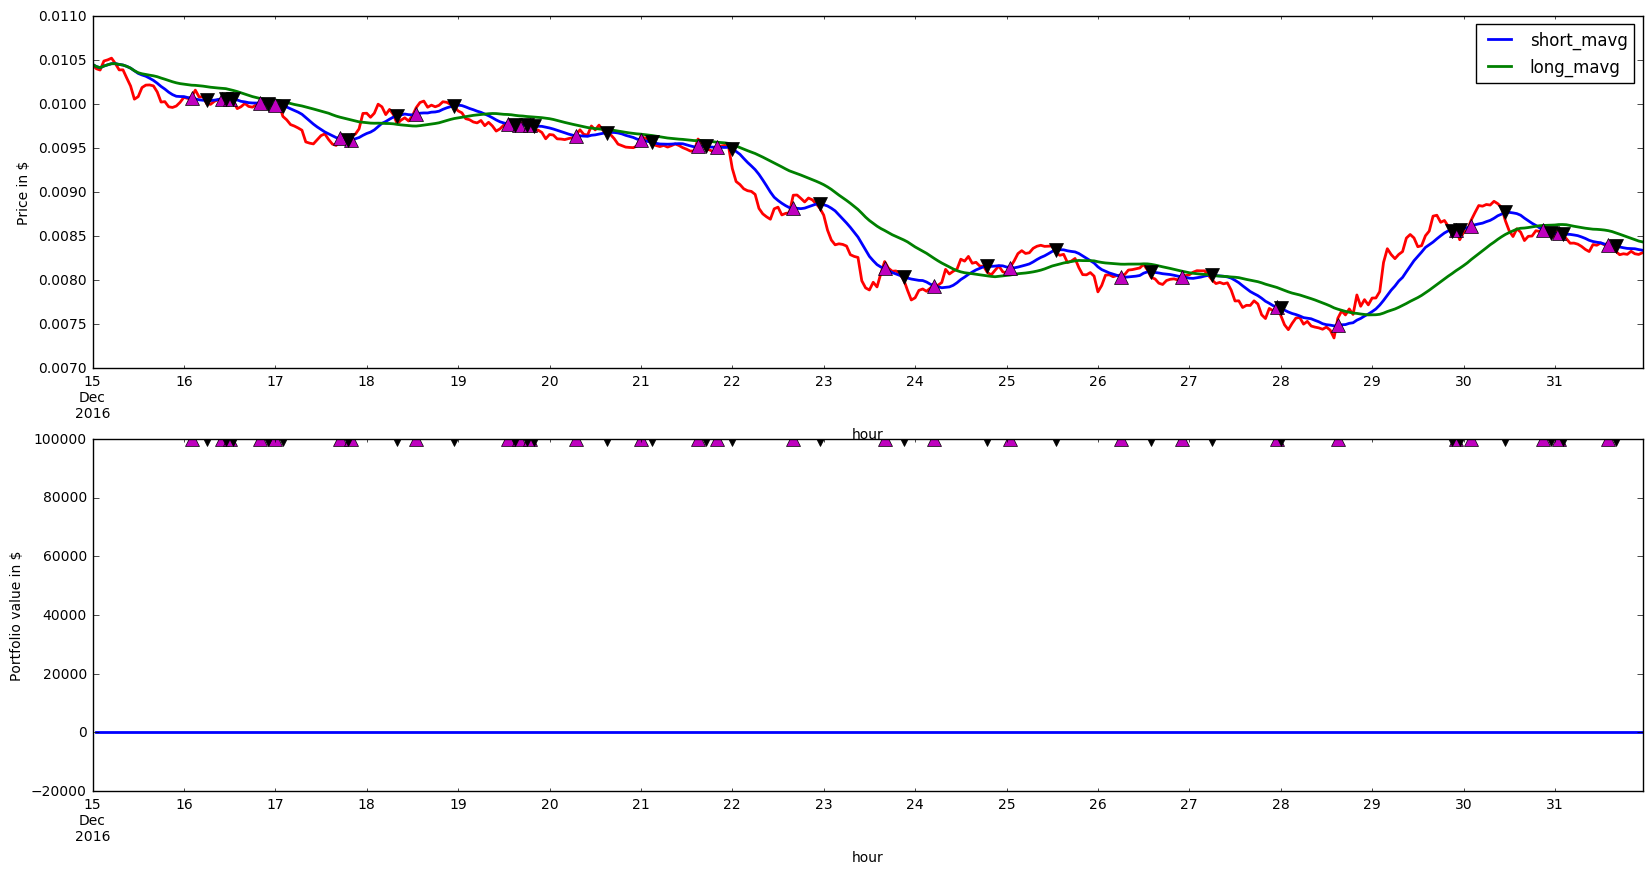

In [310]:
    prices = trade_data['ETH'].rate['mean'].sort_index()

    # Create a Moving Average Cross Strategy instance with a short moving
    # average window of 100 days and a long window of 400 days
    mac = MovingAverageCrossStrategy(prices)
    signals = mac.generate_signals()

    # Create a portfolio of AAPL, with $100,000 initial capital
    portfolio = MarketOnClosePortfolio(prices, signals)


    # Plot two charts to assess trades and equity curve
    fig = plt.figure(figsize=(20,10))
    fig.patch.set_facecolor('white')     # Set the outer colour to white
    ax1 = fig.add_subplot(211,  ylabel='Price in $')
    
    # Plot the AAPL closing price overlaid with the moving averages
    prices.plot(ax=ax1, color='r', lw=2.)
    signals[['short_mavg','long_mavg']].plot(ax=ax1, lw=2.)

    # Plot the "buy" trades against AAPL
    ax1.plot(signals.ix[signals.positions == 1.0].index.values, 
             signals.short_mavg[signals.positions == 1.0],
             '^', markersize=10, color='m')

    # Plot the "sell" trades against AAPL
    ax1.plot(signals.ix[signals.positions == -1.0].index.values, 
             signals.short_mavg[signals.positions == -1.0],
             'v', markersize=10, color='k')
    
    
    

    # Plot the equity curve in dollars
    ax2 = fig.add_subplot(212, ylabel='Portfolio value in $')
    portfolio.portfolio.returns.plot(ax=ax2, lw=2.)

    # Plot the "buy" and "sell" trades against the equity curve
    
    ax2.plot(returns.ix[signals.positions == 1.0].index.values, 
             returns.total[signals.positions == 1.0],
             '^', markersize=10, color='m')
    ax2.plot(returns.ix[signals.positions == -1.0].index.values, 
             returns.total[signals.positions == -1.0],
             'v', markersize=10, color='k')

    # Plot the figure
    fig.show()
    

In [328]:
# Declare the components with respective parameters
from data import PoloniexDataHandler
from strategy import BuyAndHoldStrategy
from portfolio import NaivePortfolio
from queue import Queue

events = Queue()
markets = top_markets.Volume.sort_values(ascending=False).head().index.tolist()
market_data = PoloniexDataHandler(markets=markets, events=events)
strategy = BuyAndHoldStrategy(market_data, events)
port = NaivePortfolio(market_data, events)

while True:
    # Update the bars (specific backtest code, as opposed to live trading)
    if market_data.continue_backtest == True:
        market_data.update_market_snapshots()
    else:
        break
    
    # Handle the events
    while True:
        try:
            event = events.get(False)
        except Queue.Empty:
            break
        else:
            if event is not None:
                if event.type == 'MARKET':
                    strategy.calculate_signals(event)
                    port.update_timeindex(event)

                elif event.type == 'SIGNAL':
                    port.update_signal(event)

                elif event.type == 'ORDER':
                    broker.execute_order(event)

                elif event.type == 'FILL':
                    port.update_fill(event)

    # 10-Minute heartbeat
    time.sleep(5)

TypeError: get_trades() takes 3 positional arguments but 4 were given

In [295]:

py.iplot([go.Scatter(x=prices.index.values,y=prices.values)])

PlotlyError: The `figure_or_data` positional argument must be either `dict`-like or `list`-like.

In [279]:
prices[1:][np.diff(prices.index.values) < 1]

hour
2016-12-27 19:00    0.007608
2016-12-24 07:00    0.007975
2016-12-22 09:00    0.008721
2016-12-19 20:00    0.009688
2016-12-16 19:00    0.009993
2016-12-15 00:00    0.010452
Freq: H, Name: mean, dtype: float64

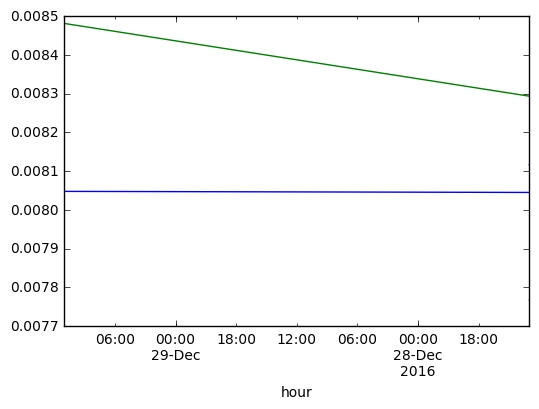

In [231]:

start = 100
end = 180
signals.long_mavg[start:end].plot()
prices[start:end].plot()

In [ ]:
import statsmodels.api as sm
# If the observations are in a dataframe, you can use statsmodels.formulas.api to do the regression instead
from statsmodels import regression
import statsmodels.formula.api as smf


In [108]:
X = sm.add_constant( np.column_stack( (X1, X2) ) )

# Run the model
results = regression.linear_model.OLS(Y, X).fit()

In [146]:
# Run multiple linear regression using asset2 and SPY as independent variables
asset1 = trade_data['XMR'].rate['mean']
asset2 = trade_data['ETH'].rate['mean']
benchmark = trade_data['BTC'].rate['mean']

mlr = regression.linear_model.OLS(asset1, sm.add_constant(np.column_stack([asset2,benchmark]))).fit()

prediction = mlr.params[0] + mlr.params[1]* + mlr.params[2]*benchmark
prediction.name = 'Prediction'
print ('MLR beta of asset2: {} \nMLR beta of BTC: {}'.format(mlr.params[1], mlr.params[2]))

MLR beta of asset2: -1.114517565231268 
MLR beta of BTC: -6.3690359143899816e-06


In [147]:
mlr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   mean   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     73.86
Date:                Sat, 18 Feb 2017   Prob (F-statistic):           4.51e-28
Time:                        20:57:42   Log-Likelihood:                 2189.8
No. Observations:                 408   AIC:                            -4374.
Df Residuals:                     405   BIC:                            -4362.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.0269      0.002     14.542      0.000         0.023     0.031
x1            -1.1145      0.101    -11.052      0.000        -1.313    -0.916
x2         -6.369e-06   1.24e-06     -5.152      0.000      -8.8e-06 -3.94e-06
==============================================================================
Omnibus:                       10.418   Durbin-Watson:                   0.059
Prob(Omnibus):                  0.005   Jarque-Bera (JB):                9.687
Skew:                           0.325   Prob(JB):                      0.00788
Kurtosis:                       2.615   Cond. No.                     1.56e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.56e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [150]:
np.corrcoef(asset2,benchmark)[0,1]

-0.76225133978346371

/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_corr is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=100).corr(other=<Series>)
  if __name__ == '__main__':


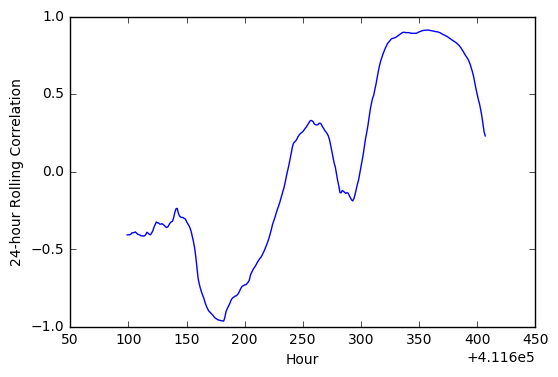

In [156]:
rolling_correlation = pd.rolling_corr(asset1, benchmark, 100)
plt.plot(rolling_correlation)
plt.xlabel('Hour')
plt.ylabel('24-hour Rolling Correlation')

In [ ]:
for market, file_name in trade_data.items():
    print('{} {} MB'.format(market, os.path.getsize(file_name) * 1e-6))

In [ ]:
alt_df = alt_df.convert_objects(convert_numeric=True,convert_dates=True)
alt_df['date'] = pd.to_datetime(alt_df.date, errors='coerce', infer_datetime_format=True)
btc_df = btc_df.convert_objects(convert_numeric=True,convert_dates=True)
btc_df['date'] = pd.to_datetime(btc_df.date, errors='coerce', infer_datetime_format=True)

In [ ]:
def get_volume_level(total):
    try: 
        total = float(total)
        level = 'very_low'
        if 0.2 <= total <= 1:
            level = 'low'
        elif 1 <= total <= 5:
            level = 'medium'
        elif 5 <= total <= 10:
            level = 'high'
        elif 10 <= total:
            level = 'very_high'
        return level
    except:
        return np.nan
    
full_df['volume_level'] = full_df.total.apply(get_volume_level)

In [ ]:
full_df['volume_level'].value_counts() / full_df.shape[0] * 100#.sort_values(0).plot(kind='barh',figsize=(20,15), fontsize=16, color='#2C8399')

More than 75% of the trades are considered very low volume. The threshold for this categorization was any trade of less than 0.2 BTC or about 125 USD. We'll first look into the 25% of the trades that had more capital behind them. 

In [ ]:
total_vol_by_level = full_df.groupby('volume_level').total.sum().sort_values(0, ascending=False).to_frame()

total_vol_by_level['pct'] = total_vol_by_level.total / total_vol_by_level.values.sum() * 100
total_vol_by_level

In [ ]:
full_trades = full_trades[full_trades.volume_level!='very_low']
xmr_trades.shape

** Group trades by time interval, type and volume level **

In [ ]:
grouped_trades = (xmr_trades[['type','rate','total', 'volume_level','time_interval']].dropna(how='all')
    .groupby(['time_interval','type','volume_level']).describe()
    .unstack(['type','volume_level', 3]).astype(float))

grouped_trades.head()

** Get the percentage change of each each feature **

In [ ]:
num_periods = 4 * 24 # the next day
change = grouped_trades.diff(num_periods) 
pct_change = (change / grouped_trades).reset_index()[num_periods:].reset_index()
full_df = (grouped_trades.reset_index()[:-num_periods].reset_index()
           .merge(pct_change, right_index=True, left_index=True, suffixes=('_value','_pct_change'))
           .set_index('time_interval_value'))
del full_df['index_value']
del full_df['index_pct_change']
full_df.head(10).fillna('')

In [ ]:
full_df.to_csv('data/xmr_15m_trade_data_20160801_20161001.csv')

** Get datapoints that precipitate a spike in price **

In [ ]:
upward_spikes = full_df[full_df['rate_pct_change','buy','low','top'] > 0.12]
upward_spikes.shape

In [ ]:
downward_spikes = full_df[full_df['rate_pct_change','sell','low','top'] < -0.12]
downward_spikes.shape

In [ ]:
buy_vol_up = full_df[full_df['total_pct_change','buy','medium','top'] > 0.7]
buy_vol_up.shape

In [ ]:
sell_vol_up = full_df[full_df['total_pct_change','sell','medium','top'] > 0.7]
sell_vol_up.shape

In [ ]:
price_series = 'rate_value','buy','low','top'
plt.figure(figsize=(20,10))
plt.plot(full_df.index, full_df[price_series], color='black', alpha=0.3, label='Price')
plt.scatter(upward_spikes.index, upward_spikes[price_series], marker='^', color='y', label='Buy Opportunity')
plt.scatter(downward_spikes.index, downward_spikes[price_series], marker='v', color='r', label='Sell Opportunity')
plt.legend()
plt.show()

** Create a series for categorical labels **
* -1: sell opportunity
* 0: neutral
* 1: buy opportunity

In [ ]:
def get_labels(period):
    if period['rate_pct_change','buy','low','top'] > 0.12:
        return 1
    if period['rate_pct_change','sell','low','top'] < -0.12:
        return -1
    else:
        return 0
              

labels = full_df.apply(get_labels, axis=1)
labels.name = 'label'
labels.value_counts()

### Reddit Data



In [ ]:
from requests import get
from io import StringIO

xmr_reddit_comments = 'https://storage.googleapis.com/springboard-145615.appspot.com/reddit'
xmr_reddit_comments = StringIO(get(xmr_reddit_comments).content.decode('utf-8'))

comments = pd.read_csv(xmr_reddit_comments)[['body','created_utc','author']]
comments['created_utc'] = pd.to_datetime(comments.created_utc)
comments['time_interval'] = (comments.created_utc.astype(datetime)
                  .apply(lambda dt: time_interval(dt, timedelta(minutes=15))))
comments = comments.set_index('created_utc')
comments.head()

In [ ]:
comments.shape


In [ ]:
time_intervals = (comments.reset_index().created_utc.astype(datetime)
                  .apply(lambda dt: time_interval(dt, timedelta(minutes=15))))
time_intervals.index = comments.index
comments['time_interval'] = time_intervals
comments.head()

In [ ]:
comments_at_first_spike = comments.reset_index().set_index('time_interval')['2016-08-16 00:00:00':'2016-08-28 00:00:00']
comments_at_first_spike.shape

In [ ]:
def get_y(c):
    try:
        return labels.ix[c.time_interval]
    except Exception as e:
        return np.nan

In [ ]:
y_labels = comments.apply(get_y, axis=1)==1
y_labels.value_counts()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(comments_at_first_spike.body.values, y_labels, 
                                                    test_size=0.33, random_state=42)

print("%d training examples (%d positive)" % (len(y_train), sum(y_train)))
print("%d test examples (%d positive)" % (len(y_test), sum(y_test)))


###  [Use LSA to vectorize the articles.](https://github.com/chrisjmccormick/LSA_Classification/blob/master/runClassification_LSA.py)

Tfidf vectorizer:
   - Strips out “stop words”
   - Filters out terms that occur in more than half of the docs (max_df=0.5)
   - Filters out terms that occur in only one document (min_df=2).
   - Selects the 10,000 most frequently occuring words in the corpus.
   - Normalizes the vector (L2 norm of 1.0) to normalize the effect of 
     document length on the tf-idf values. 

In [ ]:
vectorizer = TfidfVectorizer(max_df=0.5, max_features=10000,
                             min_df=2, stop_words='english',
                             use_idf=True)

X_train_tfidf = vectorizer.fit_transform(X_train)

print("Actual number of tfidf features: %d" % X_train_tfidf.get_shape()[1])

Project the tfidf vectors onto the first 150 principal components.
Though this is significantly fewer features than the original tfidf vector,
they are stronger features, and the accuracy is higher.

In [ ]:
svd = TruncatedSVD(100)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(int(explained_variance * 100)))

In [ ]:
# Now apply the transformations to the test data as well.
X_test_tfidf = vectorizer.transform(X_test)
X_test_lsa = lsa.transform(X_test_tfidf)

In [ ]:
###############################################################################
#  Run classification of the test articles
###############################################################################

print("\nClassifying tfidf vectors...")

# Time this step.
t0 = time.time()

# Build a k-NN classifier. Use k = 5 (majority wins), the cosine distance, 
# and brute-force calculation of distances.
knn_tfidf = KNeighborsClassifier(n_neighbors=5, algorithm='brute', metric='cosine')
knn_tfidf.fit(X_train_tfidf, y_train)

# Classify the test vectors.
p = knn_tfidf.predict(X_test_tfidf)

# Measure accuracy
numRight = 0;
for i in range(0,len(p)):
    if p[i] == y_test[i]:
        numRight += 1

print("  (%d / %d) correct - %.2f%%" % (numRight, len(y_test), float(numRight) / float(len(y_test)) * 100.0))

# Calculate the elapsed time (in seconds)
elapsed = (time.time() - t0)
print("  done in %.3fsec" % elapsed)

In [ ]:
print("\nClassifying LSA vectors...")

# Time this step.
t0 = time.time()

# Build a k-NN classifier. Use k = 5 (majority wins), the cosine distance, 
# and brute-force calculation of distances.
knn_lsa = KNeighborsClassifier(n_neighbors=5, algorithm='brute', metric='cosine')
knn_lsa.fit(X_train_lsa, y_train)

# Classify the test vectors.
p = knn_lsa.predict(X_test_lsa)

# Measure accuracy
numRight = 0;
for i in range(0,len(p)):
    if p[i] == y_test[i]:
        numRight += 1

print("  (%d / %d) correct - %.2f%%" % (numRight, len(y_test), float(numRight) / float(len(y_test)) * 100.0))

# Calculate the elapsed time (in seconds)
elapsed = (time.time() - t0)    
print("    done in %.3fsec" % elapsed)

In [ ]:
! 